In [ ]:
import pandas as pd

In [ ]:
sheet = pd.read_excel("./data/test.xlsx",usecols=[1,2,9,10]) # DataFrame 读取1,2,9,10列 从第0列开始

In [ ]:
sheet

In [ ]:
type(sheet)

In [ ]:
sheet0 = sheet.loc[sheet['site'] == 0]
sheet0

In [ ]:
import numpy as np
sheet0 = sheet0.replace(-1,np.nan)
sheet0.interpolate('linear', inplace=True)#补全所有缺失值
sheet0

In [ ]:
sheet0.drop(labels=['site'], axis=1,inplace = True)
sheet0

In [ ]:
sheet0.to_excel('./data/sheet0.xlsx',columns=['date','time','pm25'],index=False)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import os

# 读取数据 (10个站点)
sites = {}
for i in range(10):
    site = pd.read_excel('./data/site'+str(i)+'.xlsx')
    sites[i] = site

In [ ]:
for i in range(10):
    print(len(sites[i]))

In [ ]:
sites[0].interpolate('linear', inplace=True)  # 补全所有缺失值 会报错

In [ ]:
sites[0]

In [ ]:
sites[1].interpolate('linear', inplace=True)
sites[1]

In [ ]:
sites[2].interpolate('linear', inplace=True)
sites[2]

In [ ]:
sites[2].drop(index=[0],inplace=True)
sites[2]

In [ ]:
sites[2].iloc[0:34668 - 365 * 24, 1:]

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import os
import joblib

In [22]:
def generate_dataset(site, site_index):
    '''
    传入一个站点的数据集、切割数据集,传入站点的序号(0-9)
    返回训练集、测试集
    '''
    l = 34668  # len(sites) = 34668
    training_set = site.iloc[0:l - 365 * 24, 2:]  # iloc只取行号，而非index
    test_set = site.iloc[l - 365 * 24:, 2:]

    # 对训练集和测试集数据进行归一化
    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    test_set = sc.transform(test_set)
    
    # 存 scaler
    joblib.dump(sc, './scaler/sc' + str(site_index) + '.pkl')

    return training_set_scaled, test_set

In [23]:
def process_data(data_scaled, time_step=24):
    '''
    time_step: 使用 time_step 个时间步用于预测，default:24
    data_scaled: 经过归一化的数据、传入训练集或测试集
    返回值: x,y为 RNN-based model 输入数据的维度要求
    '''

    # 初始化训练集
    x = []
    y = []

    # x
    for i in range(time_step, len(data_scaled)):
        x.append(data_scaled[i - time_step:i, 0])

    # y
    for i in range(time_step + 24, len(data_scaled)):
        y.append(data_scaled[i - time_step:i, 0])

    x = x[0:len(y)]

    # 对训练集进行打乱
    np.random.seed(7)
    np.random.shuffle(x)
    np.random.seed(7)
    np.random.shuffle(y)
    tf.random.set_seed(7)

    # 将训练集由list格式变为array格式
    x, y = np.array(x), np.array(y)

    # 使 x 符合 RNN 输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
    x = np.reshape(x, (x.shape[0], time_step, 1))

    return x, y

In [24]:
def create_model():
    model = tf.keras.Sequential([
        LSTM(80, return_sequences=True),
        Dropout(0.2),
        LSTM(100),
        Dropout(0.2),
        Dense(24)  # 被预测的 24
    ])
    return model

In [25]:
def get_rmse(predicted_pm25, real_pm25):
    predicted_pm25_T = predicted_pm25.T
    real_pm25_T = real_pm25.T

    rmse = []
    for i in range(len(predicted_pm25_T)):
        rmse.append(math.sqrt(mean_squared_error(predicted_pm25_T[i], real_pm25_T[i])))

    return rmse


def get_mae(predicted_pm25, real_pm25):
    predicted_pm25_T = predicted_pm25.T
    real_pm25_T = real_pm25.T

    mae = []
    for i in range(len(predicted_pm25_T)):
        mae.append((mean_squared_error(predicted_pm25_T[i], real_pm25_T[i])))

    return mae

In [26]:
sites = {}
for i in range(1):
    site = pd.read_excel('./data/site' + str(i) + '.xlsx')
    sites[i] = site

In [27]:
sites[0]

,date,time,pm25
0,20140822,11,NaN
1,20140822,12,36.0
2,20140822,13,35.0
3,20140822,14,32.0
4,20140822,15,29.0
...,...,...,...
34664,20180903,19,NaN
34665,20180903,20,NaN
34666,20180903,21,NaN
34667,20180903,22,NaN


In [28]:
for i in range(1):
    sites[i].interpolate('linear', inplace=True)  # 补全所有缺失值
    sites[i].drop(index=[0], inplace=True)

In [29]:
sites[0]

,date,time,pm25
1,20140822,12,36.0
2,20140822,13,35.0
3,20140822,14,32.0
4,20140822,15,29.0
5,20140822,16,27.0
...,...,...,...
34664,20180903,19,5.0
34665,20180903,20,5.0
34666,20180903,21,5.0
34667,20180903,22,5.0


train or testtrain
Train on 25860 samples, validate on 8712 samples
Epoch 1/100
25860/25860 [==============================] - 5s 213us/sample - loss: 0.0024 - val_loss: 0.0012
Epoch 2/100
25860/25860 [==============================] - 4s 142us/sample - loss: 0.0022 - val_loss: 0.0012
Epoch 3/100
25860/25860 [==============================] - 4s 144us/sample - loss: 0.0022 - val_loss: 0.0012
Epoch 4/100
25860/25860 [==============================] - 4s 144us/sample - loss: 0.0021 - val_loss: 0.0012
Epoch 5/100
25860/25860 [==============================] - 4s 142us/sample - loss: 0.0021 - val_loss: 0.0012
Epoch 6/100
25860/25860 [==============================] - 4s 142us/sample - loss: 0.0021 - val_loss: 0.0012
Epoch 7/100
25860/25860 [==============================] - 4s 145us/sample - loss: 0.0021 - val_loss: 0.0012
Epoch 8/100
25860/25860 [==============================] - 4s 147us/sample - loss: 0.0021 - val_loss: 0.0012
Epoch 9/100
25860/25860 [==============================] - 4

Epoch 75/100
25860/25860 [==============================] - 4s 153us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 76/100
25860/25860 [==============================] - 4s 149us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 77/100
25860/25860 [==============================] - 4s 152us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 78/100
25860/25860 [==============================] - 4s 153us/sample - loss: 0.0012 - val_loss: 0.0015
Epoch 79/100
25860/25860 [==============================] - 4s 154us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 80/100
25860/25860 [==============================] - 4s 149us/sample - loss: 0.0012 - val_loss: 0.0016
Epoch 81/100
25860/25860 [==============================] - 4s 148us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 82/100
25860/25860 [==============================] - 4s 150us/sample - loss: 0.0012 - val_loss: 0.0015
Epoch 83/100
25860/25860 [==============================] - 4s 150us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 84/1

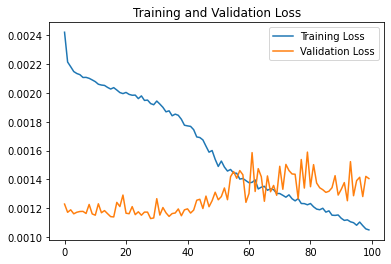

C:\qyf\app\anaconda3\envs\TF2.1\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 39044 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\qyf\app\anaconda3\envs\TF2.1\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\qyf\app\anaconda3\envs\TF2.1\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\qyf\app\anaconda3\envs\TF2.1\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\qyf\app\anaconda3\envs\TF2.1\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\qyf\app\anaconda3\envs\TF2.1\lib\site-packages\matplotlib\backends\backend_agg.py:214: 

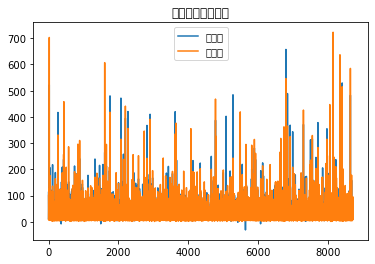

[14.84167154723566, 22.832851833222108, 27.304108225233566, 30.737219927456728, 33.58482866900713, 35.83891767655809, 37.43278188396615, 38.7311474878778, 39.51143285289362, 39.337841854176716, 39.58419960599741, 39.45048513399292, 39.64501909795833, 39.458430366521746, 38.75214148782252, 38.920323584052525, 38.359213087084235, 37.900727577284385, 38.470340267138745, 39.01465168809109, 39.052318795083714, 39.54335467381218, 40.40346955236735, 39.87596312311461]
[220.27521431602452, 521.3391228378742, 745.5143259752673, 944.7766888688429, 1127.940716726563, 1284.4280202271077, 1401.2131595725846, 1500.1017857277425, 1561.1533260887213, 1547.4658017442173, 1566.9088584474457, 1556.3407773073964, 1571.727539277481, 1556.9677269896454, 1501.7284698922156, 1514.791587887355, 1471.4292286603345, 1436.4651508875252, 1479.967080269437, 1522.1430463430693, 1525.083603272849, 1563.676898858904, 1632.4403518690751, 1590.0924349959962]


In [30]:
if input("train or test")=="train":
    for i in range(1):

        # site3 数据量有问题(少)，不跑
        if i == 3:
            continue

        training_set_scaled, test_set = generate_dataset(sites[i],i)

        x_train, y_train = process_data(training_set_scaled)
        x_test, y_test = process_data(test_set)

        model = create_model()
        model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                      loss='mean_squared_error')

        BATCH_SIZE = 32
        EPOCHS = 100

        history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), validation_freq=1)
        model.save('./model/site' + str(i) + '.h5')
        # 读取模型的方法
        # model = tf.keras.models.load_model('./model/site' + str(i) + '.h5')
        model.summary()
        
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show() 

        # 测试集输入模型进行预测
        predicted_pm25 = model.predict(x_test)

        # 对预测数据还原---从（0，1）反归一化到原始范围
        sc = joblib.load('./scaler/sc'+str(i)+'.pkl')
        predicted_pm25 = sc.inverse_transform(predicted_pm25)
        # 对真实数据还原---从（0，1）反归一化到原始范围
        real_pm25 = sc.inverse_transform(y_test)

        plt.plot(predicted_pm25.T[0], label='预测值')
        plt.plot(real_pm25.T[0], label='真实值')
        plt.title('预测值真实值对比')
        plt.legend()
        plt.show() 
        rmse = get_rmse(predicted_pm25, real_pm25)
        print(rmse)

        rmse_np = np.array(rmse)
        np.save("./result/rmse/rmse"+str(i)+".npy", rmse_np)
        mae = get_mae(predicted_pm25, real_pm25)
        print(mae)
        mae_np = np.array(mae)
        np.save("./result/mae/mae"+str(i)+".npy", rmse_np)